In [1]:
COLLAB = False # False True

In [2]:

if COLLAB:
    !pip install langdetect
    from google.colab import drive
    import pandas as pd
    drive.mount("/content/drive")
    df = pd.read_csv('/content/drive/MyDrive/full_merged_dataset15.csv', encoding='utf-8')

    from IPython.display import HTML, display

    def set_css():
        display(HTML('''
        <style>
            pre {
                white-space: pre-wrap;
            }
        </style>
        '''))
        get_ipython().events.register('pre_run_cell', set_css)
    

In [3]:
import pandas as pd
import os
import numpy as np
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import html
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import gc


In [4]:
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to /home/vm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vm/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df = pd.read_csv('full_merged_dataset15.csv', encoding='utf-8')

In [6]:
df.head()

,id,title,author,snippet,link,categories,poem
0,162275,The 80&rsquo;s Miracle Diet,By Melvin Dixon,Yours free without the asking,https://www.poetryfoundation.org/poetrymagazin...,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,162250,All Saints&rsquo;,By Corey Van Landingham,CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin.,https://www.poetryfoundation.org/poetrymagazin...,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,162279,And These Are Just a Few ...,By Melvin Dixon,This poem is for the epidemic dead and the liv...,https://www.poetryfoundation.org/poetrymagazin...,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,162248,ASMR,By Corey Van Landingham,Why not climb up the mountain,https://www.poetryfoundation.org/poetrymagazin...,[],Why not climb up the mountain of delight? To t...
4,162249,ASMR,By Corey Van Landingham,HelloÃ¢â‚¬â€Tonight,https://www.poetryfoundation.org/poetrymagazin...,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


We can remove the id, snippet and link as they are useless for the tasks we have to do.

In [7]:
columns_to_drop = ["id", "snippet", "link"]
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
df.head()

,title,author,categories,poem
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,All Saints&rsquo;,By Corey Van Landingham,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight? To t...
4,ASMR,By Corey Van Landingham,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


In [5]:

def separate_language(df, text_column):
    """
    Separate observations in a DataFrame based on the language detected in a text column.

    Args:
        df (pandas.DataFrame): Input DataFrame.
        text_column (str): Name of the column containing text data.

    Returns:
        tuple: A tuple containing two DataFrames. The first DataFrame contains observations in English,
               and the second DataFrame contains observations in other languages.
    """
    # Initialize lists to store data
    english_data = []
    other_language_data = []

    # Loop through each row in the dataset
    for index, row in df.iterrows():
        text = row[text_column]
        try:
            # Detect language of the text
            lang = detect(text)

            # Append entire row data to respective lists
            if lang == 'en':
                english_data.append(row)
            else:
                other_language_data.append(row)
        except:
            # Handle exceptions in language detection (e.g., short texts)
            pass

    # Create dataframes from lists
    english_df = pd.DataFrame(english_data)
    other_language_df = pd.DataFrame(other_language_data)

    return english_df, other_language_df

In [10]:
# Call the function to separate language
english_df, other_language_df = separate_language(df, 'poem')

In [11]:
# i want to check the size of both dfs
print(english_df.shape)
print(other_language_df.shape)

(44859, 4)
(429, 4)


Only 426 poems are not in english and we know that most of them have been translated to english. Note that this value changes as expected

In [12]:
english_df.head()


,title,author,categories,poem
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,All Saints&rsquo;,By Corey Van Landingham,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight? To t...
4,ASMR,By Corey Van Landingham,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


In [13]:
other_language_df.head()

,title,author,categories,poem
10,Fosfor,By Kacper Bartczak,[],w terrarium jesteÃ…â€º czarna skrzyneczka rzec...
29,PieÃ…â€ºÃ…â€ž tego,By Kacper Bartczak,[],perÃ…â€šo Ã…â€ºwiata wymiocino wieprzu jestem ...
32,Prawda obrazu,By Kacper Bartczak,[],Kobieta naprzeciwko czyta Ã¢â‚¬Å¾NajwiÃ„â„¢ksz...
35,regenportr&auml;t,By Jan Wagner,['Nature'],"erscheint als handkuÃƒÅ¸, als sanfter stubser,..."
37,reifen,By Jan Wagner,"['Social Commentaries', 'Cities & Urban Life']","dort, wo die stadt versickert, beim bahndamm, ..."


### Save the english DataFrame and the rest of the data

In [14]:
english_df.to_csv('english_df.csv', encoding='utf-8', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

#other languages dataset can not be codified and as we are not going to use it we dont care about it
other_language_df.to_csv('other_language_df.csv',encoding='utf-8', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used


# Small Case Text Preprocessing

In [111]:

df = pd.read_csv('english_df.csv', encoding='utf-8')

# Drop rows with missing values in the 'poem' column
df = df.dropna(subset=['poem'])

In [112]:
df.head(5)

,title,author,categories,poem
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,All Saints&rsquo;,By Corey Van Landingham,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight? To t...
4,ASMR,By Corey Van Landingham,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


In [113]:
print(df.shape)


(44859, 4)


As the poems were not well-encoded we have to substitute the bad encoding to an apostrophe (also some other characters), and expand the contractions.

In [70]:
# # Decode the UTF-8 string
# # The string to decode
# utf8_string = "Ãƒâ€šÃ‚Â"
# utf8_string = "Alongside Kara WalkerÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢s ÃƒÂ¢Ã¢â€šÂ¬Ã…â€œWokey Wokey,ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â 2021 ÃƒÂ¢Ã¢â€šÂ¬Ã¢â‚¬Â as i was saying your (idea of) death ainÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢t mine(s) i(ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢ll) sprout any how (flourish!) your rot Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â flesh donÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢t make meÃƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â  no (ting)Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â never mind ÃƒÂ¢Ã¢â€šÂ¬Ã¢â‚¬ÂÃƒâ€šÃ‚Â  s Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â t Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â r Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â e Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â t Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â c Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â h Ãƒâ€šÃ‚Â ÃƒÂ¢Ã¢â€šÂ¬Ã¢â‚¬Â not too long (just) long enough (just) dark(ish)Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  grow(th) hard as illusion(s) and furthermore ÃƒÂ¢Ã¢â€šÂ¬Ã¢â‚¬Â"

# # Decode the UTF-8 string using Windows-1252 encoding
# latin_string = utf8_string.encode('windows-1252').decode('utf-8')

# # Print the decoded Latin string
# print(latin_string)



In [146]:
# Pre-compile the patterns for efficiency
url_pattern = re.compile(r'https://\S+|www\.\S+')

chars_to_replace_by_apostrophe = re.compile(r'ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢|Ã¢â‚¬â„¢|ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢')
chars_to_replace_by_a = re.compile(r'&aacute')

unwanted_chars_pattern = re.compile(r'Ã¢â‚¬Å|Ã¢â‚¬â„¢|Ã¢â‚¬â€|â‚¬Âº|ÃƒÂ¢Ã¢â€šÂ¬Ã|Ã|¬|¢|š|€||âº|â|Âº|Ã¢|Ãƒâ€|¬ÂºÃƒâ€¦Ã¢â|¬|Å|¾|Âº|Ã¢|Âº|Ã¢â‚¬ÂºÃƒâ€|Ã¢| â |Ãƒâ€šÃ‚Â| â|â|Ã‚Â|‚Â')
#  Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â flesh donÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢t make meÃƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â Ãƒâ€šÃ‚Â  no (ting)Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â  Ãƒâ€šÃ‚Â never
def wrangle_text(text):

    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").text

    # Replace by apostrophe
    text = chars_to_replace_by_apostrophe.sub("'", text)

    # Replace by a
    text = chars_to_replace_by_a.sub('á', text)

    # Fix specific character issues in one go

    text = unwanted_chars_pattern.sub('', text)

    # Expand contractions once, after all substitutions
    text = contractions.fix(text)

    return text


In [147]:
poem = df['poem'].iloc[24] # This is the 26th poem
wrangled_poem = wrangle_text(poem)
print(colored('\n============= First poem in corpus =============', 'blue'))
print(poem)
print(colored('\n============= After wrangling result =============', 'green'))
print(wrangled_poem)


============= First poem in corpus =============
Alongside Kara WalkerÃ¢â‚¬â„¢s Ã¢â‚¬Å“Wokey Wokey,Ã¢â‚¬Â 2021 Ã¢â‚¬â€ as i was saying your (idea of) death ainÃ¢â‚¬â„¢t mine(s) i(Ã¢â‚¬â„¢ll) sprout any how (flourish!) your rot Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â flesh donÃ¢â‚¬â„¢t make meÃ‚Â Ã‚Â Ã‚Â Ã‚Â  no (ting)Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â never mind Ã¢â‚¬â€Ã‚Â  s Ã‚Â Ã‚Â t Ã‚Â Ã‚Â r Ã‚Â Ã‚Â e Ã‚Â Ã‚Â t Ã‚Â Ã‚Â c Ã‚Â Ã‚Â h Ã‚Â Ã¢â‚¬â€ not too long (just) long enough (just) dark(ish)Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  grow(th) hard as illusion(s) and furthermore Ã¢â‚¬â€

============= After wrangling result =============
Alongside Kara Walker's “Wokey Wokey,‚Â 2021  as i was saying your (idea of) death are not mine(s) i( will) sprout any how (flourish!) your rot         flesh do not make me     no (ting)                                         never mind   s   t   are   e   t   c   h   not too long (just) long enou

In [148]:
poem = df['poem'].iloc[84] # This is the 84th poem
wrangled_poem = wrangle_text(poem)
print(colored('\n============= First poem in corpus =============', 'blue'))
print(poem)
print(colored('\n============= After wrangling result =============', 'green'))
print(wrangled_poem)


============= First poem in corpus =============
I want to believe IÃ¢â‚¬â„¢m on my last life. What is nirvana if not a kind of death? In a past life, a stranger asked the Buddha for his children. The Buddha offered him his eyes. Then, pulling the children, screaming, from the shivering rice barrels, he gave them away. Did the children ever forgive him? Did they have to because he was the Buddha? I stay awake, listening to my brotherÃ¢â‚¬â„¢s breath as he sleeps in my corridor. A 6 am flight, a half-hug in the parking lot. I want one more life. This is the problem with reincarnation: you donÃ¢â‚¬â„¢t know if what youÃ¢â‚¬â„¢ve lost is lost forever. Unless, I guess, youÃ¢â‚¬â„¢re the Buddha. His children escaped, by the way. Hid from their possessor in the cane grass, the silk reeds, and wove their way back home. I think they hugged their mother. I think the Buddha demanded understanding. I had to, he likely said. I wonder who they became in their next life. I wonder if the siblings st

Now we are going to tokenize the poems by words and by sentences

In [149]:
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize


print(colored('\n============= First poem in data =============', 'blue'))
print(wrangled_poem)

# Tokenize the review
poem_tokens = wordpunct_tokenize(wrangled_poem)
# Tokenize the review at the sentence level
poem_tokens_sent = sent_tokenize(wrangled_poem)

print(colored('\n============= First poem (tokens) =============', 'green'))
print(poem_tokens)

print(colored('\n============= First poem (tokens sent level) =============', 'red'))
print(poem_tokens_sent)


============= First poem in data =============
I want to believe I am on my last life. What is nirvana if not a kind of death? In a past life, a stranger asked the Buddha for his children. The Buddha offered him his eyes. Then, pulling the children, screaming, from the shivering rice barrels, he gave them away. Did the children ever forgive him? Did they have to because he was the Buddha? I stay awake, listening to my brother's breath as he sleeps in my corridor. A 6 am flight, a half-hug in the parking lot. I want one more life. This is the problem with reincarnation: you do not know if what you have lost is lost forever. Unless, I guess, you are the Buddha. His children escaped, by the way. Hid from their possessor in the cane grass, the silk reeds, and wove their way back home. I think they hugged their mother. I think the Buddha demanded understanding. I had to, he likely said. I wonder who they became in their next life. I wonder if the siblings stayed together, across this ever-

### Converting into lower case & removing non alphanumeric:

In [150]:
poem_tokens_filtered = [token.lower() for token in poem_tokens if token.isalnum()]

# The isalnum() method returns True if all characters in the string are
# alphanumeric (either alphabets or numbers). If not, it returns False.

print(colored('\n============= First poem (tokens) =============', 'blue'))
print(poem_tokens)

print(colored('\n============= First poem (tokens filtered) =============', 'green'))
print(poem_tokens_filtered)


============= First poem (tokens) =============
['I', 'want', 'to', 'believe', 'I', 'am', 'on', 'my', 'last', 'life', '.', 'What', 'is', 'nirvana', 'if', 'not', 'a', 'kind', 'of', 'death', '?', 'In', 'a', 'past', 'life', ',', 'a', 'stranger', 'asked', 'the', 'Buddha', 'for', 'his', 'children', '.', 'The', 'Buddha', 'offered', 'him', 'his', 'eyes', '.', 'Then', ',', 'pulling', 'the', 'children', ',', 'screaming', ',', 'from', 'the', 'shivering', 'rice', 'barrels', ',', 'he', 'gave', 'them', 'away', '.', 'Did', 'the', 'children', 'ever', 'forgive', 'him', '?', 'Did', 'they', 'have', 'to', 'because', 'he', 'was', 'the', 'Buddha', '?', 'I', 'stay', 'awake', ',', 'listening', 'to', 'my', 'brother', "'", 's', 'breath', 'as', 'he', 'sleeps', 'in', 'my', 'corridor', '.', 'A', '6', 'am', 'flight', ',', 'a', 'half', '-', 'hug', 'in', 'the', 'parking', 'lot', '.', 'I', 'want', 'one', 'more', 'life', '.', 'This', 'is', 'the', 'problem', 'with', 'reincarnation', ':', 'you', 'do', 'not', 'know', 'i

Now we use stemming or lemmatization.

In [151]:
stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

stemmed_poem = [stemmer.stem(el) for el in poem_tokens_filtered]
print(colored('\n============= Stemmed review  =============', 'blue'))
print(stemmed_poem)

lemmatized_poem = [wnl.lemmatize(el) for el in poem_tokens_filtered]
print(colored('\n============= Lemmatized review  =============', 'blue'))
print(lemmatized_poem)

# The difference between both is that the lemmatization process is more complex
# and it involves resolving words to their base or root form.

# Lemmatization: Lemmatization is the process of converting a word to its base form.
# Stemming: Stemming is the process of reducing a word to its root form.

# For example:
# Lemmatization: The word "better" is converted to "good".
# Stemming: The word "better" is converted to "bet".


============= Stemmed review  =============
['i', 'want', 'to', 'believ', 'i', 'am', 'on', 'my', 'last', 'life', 'what', 'is', 'nirvana', 'if', 'not', 'a', 'kind', 'of', 'death', 'in', 'a', 'past', 'life', 'a', 'stranger', 'ask', 'the', 'buddha', 'for', 'his', 'children', 'the', 'buddha', 'offer', 'him', 'his', 'eye', 'then', 'pull', 'the', 'children', 'scream', 'from', 'the', 'shiver', 'rice', 'barrel', 'he', 'gave', 'them', 'away', 'did', 'the', 'children', 'ever', 'forgiv', 'him', 'did', 'they', 'have', 'to', 'becaus', 'he', 'was', 'the', 'buddha', 'i', 'stay', 'awak', 'listen', 'to', 'my', 'brother', 's', 'breath', 'as', 'he', 'sleep', 'in', 'my', 'corridor', 'a', '6', 'am', 'flight', 'a', 'half', 'hug', 'in', 'the', 'park', 'lot', 'i', 'want', 'one', 'more', 'life', 'this', 'is', 'the', 'problem', 'with', 'reincarn', 'you', 'do', 'not', 'know', 'if', 'what', 'you', 'have', 'lost', 'is', 'lost', 'forev', 'unless', 'i', 'guess', 'you', 'are', 'the', 'buddha', 'his', 'children', 'es

# Preprocessing of the whole dataset

Now we have added a stage where we remove stopwords

In [152]:
import numpy as np

df = pd.read_csv('english_df.csv', encoding='utf-8')

# Drop rows with missing values in the 'poem' column
df = df.dropna(subset=['poem'])

In [153]:
print(df.shape)

(44859, 4)


In [154]:
df2 = df.copy()
df2['poem'] = df['poem'].apply(lambda x: wrangle_text(x))

/tmp/ipykernel_2581/1760213790.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [155]:
df2.to_csv('data_wrangled.csv',encoding='latin-1', errors='ignore', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [156]:
from nltk.corpus import stopwords
# Initialize NLTK resources
stopwords_en = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def prepare_data(text, tool='lemmatize'):

    # Wrangle text
    text = wrangle_text(text)

    # Tokenize text
    tokens = wordpunct_tokenize(text)

    # Filter tokens
    tokens_filtered = [token.lower() for token in tokens if token.isalnum()]

    if tool == 'stem':
        # Stem tokens
        tokens_filtered = [stemmer.stem(el) for el in tokens_filtered]
    elif tool == 'lemmatize':
        # Lemmatize tokens
        tokens_filtered = [wnl.lemmatize(el) for el in tokens_filtered]
    else:
        raise ValueError('Invalid tool. Please select either "stem" or "lemmatize".')

    # Remove stopwords
    clean_tokens = [el for el in tokens_filtered if el not in stopwords_en]

    return clean_tokens

### Processing of the poems column

In [157]:
# Now lets use the original text and check it:
print(colored('\n============= First review in corpus =============', 'blue'))
poem = df2['poem'].iloc[84]
print(poem)

# Prepare the data
clean_tokens = prepare_data(poem, tool = "lemmatize")
print(colored('\n============= Clean tokens =============', 'green'))
print(clean_tokens)



============= First review in corpus =============
I want to believe I am on my last life. What is nirvana if not a kind of death? In a past life, a stranger asked the Buddha for his children. The Buddha offered him his eyes. Then, pulling the children, screaming, from the shivering rice barrels, he gave them away. Did the children ever forgive him? Did they have to because he was the Buddha? I stay awake, listening to my brother's breath as he sleeps in my corridor. A 6 am flight, a half-hug in the parking lot. I want one more life. This is the problem with reincarnation: you do not know if what you have lost is lost forever. Unless, I guess, you are the Buddha. His children escaped, by the way. Hid from their possessor in the cane grass, the silk reeds, and wove their way back home. I think they hugged their mother. I think the Buddha demanded understanding. I had to, he likely said. I wonder who they became in their next life. I wonder if the siblings stayed together, across this e

In [158]:
# Apply the prepare_data function to clean the poems
df2['clean_tokens'] = df2['poem'].apply(lambda x: prepare_data(x, tool='lemmatize'))

/tmp/ipykernel_2581/1760213790.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [159]:
df2.head()

,title,author,categories,poem,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...,"[free, without, asking, quick, delivery, via, ..."
1,All Saints&rsquo;,By Corey Van Landingham,[],Caravaggio's face in the sunken pumpkin. Bulbs...,"[caravaggio, face, sunken, pumpkin, bulb, rott..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...,"[poem, epidemic, dead, living, remember, neigh..."
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight? To t...,"[climb, mountain, delight, world, thin, meridi..."
4,ASMR,By Corey Van Landingham,[],"HelloTonight we will trace the static bough, t...","[hellotonight, trace, static, bough, temporali..."


In [160]:
# remove the column 'poem'
df2 = df2.drop(columns=['poem'])

In [161]:
print(df.shape)

(44859, 4)


In [162]:
df2.to_csv('data_poems_preprocessed.csv', encoding='latin-1',errors='ignore', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [163]:
df2.head(27)

,title,author,categories,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']","[free, without, asking, quick, delivery, via, ..."
1,All Saints&rsquo;,By Corey Van Landingham,[],"[caravaggio, face, sunken, pumpkin, bulb, rott..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...","[poem, epidemic, dead, living, remember, neigh..."
3,ASMR,By Corey Van Landingham,[],"[climb, mountain, delight, world, thin, meridi..."
4,ASMR,By Corey Van Landingham,[],"[hellotonight, trace, static, bough, temporali..."
5,Autumn Leaving,By Melvin Dixon,[],"[didier, vermont, leaf, glass, hand, working, ..."
6,Babble,By Nica Giromini,[],"[say, land, remembered, muddy, rush, slows, ne..."
7,Chiaroscuro Spring time,By Cyrus Cassells,"['Arts & Sciences', 'Painting & Sculpture']","[galleria, nazionale, arte, antica, rome, wa, ..."
8,Currency,By Nica Giromini,[],"[net, headfirst, prairie, spring, seeing, noth..."
9,Everyday around the world a woman is pulled in...,By Krista Franklin,"['Types/Modes', 'Ekphrasis']","[kara, walker, blue, 2020, everyday, brown, wo..."


In [164]:
del df2
del df
gc.collect()

17147

# Text vectorization

In this part of the notebook we are going to analyze the following vectorization schemes:
- Classical BoW or TF-IDF representation.
- Word2vec/Glove based representation or Doc2Vec vectorization.
- Extraction of themes and vector representation of the documents
using the LDA algorithm.


In [165]:
# For colab
if COLLAB:
    data = pd.read_csv('/content/drive/MyDrive/data_poems_preprocessed.csv', encoding='latin-1')
# For local
else: 
    data = pd.read_csv('data_poems_preprocessed.csv', encoding='latin-1')

data.head(5)

,title,author,categories,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']","['free', 'without', 'asking', 'quick', 'delive..."
1,All Saints&rsquo;,By Corey Van Landingham,[],"['caravaggio', 'face', 'sunken', 'pumpkin', 'b..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...","['poem', 'epidemic', 'dead', 'living', 'rememb..."
3,ASMR,By Corey Van Landingham,[],"['climb', 'mountain', 'delight', 'world', 'thi..."
4,ASMR,By Corey Van Landingham,[],"['hellotonight', 'trace', 'static', 'bough', '..."


We will use Gensim, so we need to create a corpus, that is a list of the poems tokenized.

In [166]:
import ast  # To parse the string representation of lists in DataFrame
clean_tokens =  data['clean_tokens'].apply(ast.literal_eval)

# Convert the pandas series to a list of lists
corpus = clean_tokens.tolist()

In [167]:
print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))
print(colored('\n============= First review =============', 'blue'))
print(corpus[0])

Number of documents in corpus: 44859

============= First review =============
['free', 'without', 'asking', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handling', 'ten', 'year', 'incubation', 'lost', '40', 'pound', 'two', 'week', 'cocktail', 'perrier', 'twist', 'azt', 'bactrim', 'broiled', 'bacon', 'bit', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'going', 'smoke', 'act', 'dial', '1', '800', 'got', '2', 'operator', 'standing', 'photograph', 'prove', 'passed', 'away']


Now we are going to see the number of tokens per poem

Average number of tokens per poem: 108.45507033148309


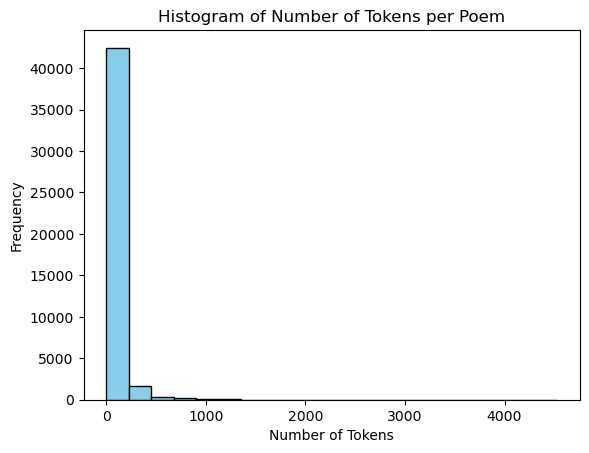

In [168]:
from nltk.tokenize import wordpunct_tokenize

# Tokenize each review and calculate the number of tokens
num_tokens_per_review = [len(review) for review in corpus]

# Calculate the average number of tokens per review
average_tokens_per_review = sum(num_tokens_per_review) / len(num_tokens_per_review)
print("Average number of tokens per poem:", average_tokens_per_review)

import matplotlib.pyplot as plt

# Plot histogram
plt.hist(num_tokens_per_review, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens per Poem')
plt.show()

So we can see that most of the poems have around 100 tokens. Now we are going to use n-gramm detection to join tokens that appear together frequently.

In [169]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

print(colored('\n============= First poem in corpus =============', 'blue'))
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print(colored('\n============= First poem after N-gram replacement =============', 'blue'))
print(corpus[0])


============= First poem in corpus =============
['free', 'without', 'asking', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handling', 'ten', 'year', 'incubation', 'lost', '40', 'pound', 'two', 'week', 'cocktail', 'perrier', 'twist', 'azt', 'bactrim', 'broiled', 'bacon', 'bit', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'going', 'smoke', 'act', 'dial', '1', '800', 'got', '2', 'operator', 'standing', 'photograph', 'prove', 'passed', 'away']

============= First poem after N-gram replacement =============
['free', 'without', 'asking', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handling', 'ten_year', 'incubation', 'lost', '40', 'pound', 'two', 'week', 'cocktail', 'perrier', 'twist', 'azt', 'bactrim', 'broiled', 'bacon', 'bit', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body'

In [170]:
data['clean_tokens'] = corpus

To be able to work with the corpus, we need to vectorize all its documents. To do so, there are two steps we need to carry out:

- Calculate the dictionary
- Transform the documents using the dictionary

In [171]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 156916 terms
First terms in the dictionary:
0 : 1_800
1 : 2
2 : 40
3 : ablaze
4 : act
5 : asking
6 : away
7 : azt
8 : bacon
9 : bactrim


Now we are going to filter tokens that appears just once in a poem, and then see what is the most common and less common tokens.

Number of tokens appearing in exactly one document: 68075
Most common token: like
Least common token: pleasingly


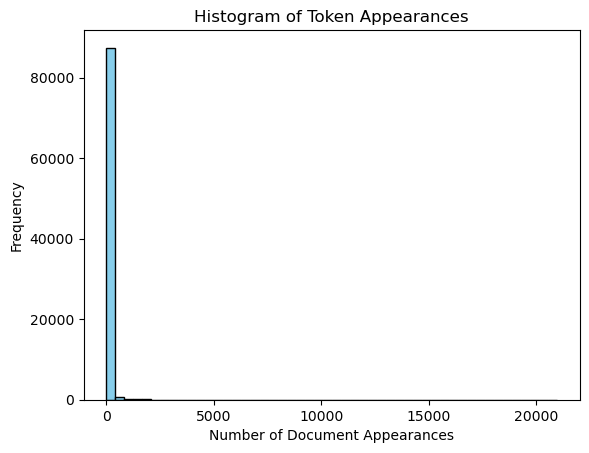

In [172]:
# Count the number of documents where each token appears
token_ndocs = {}
for doc in corpus:
    unique_tokens = set(doc)
    for token in unique_tokens:
        token_ndocs[token] = token_ndocs.get(token, 0) + 1

# Create DataFrame from token_ndocs
df_token_ndocs = pd.DataFrame(token_ndocs.items(), columns=['token', 'ndocs'])

# Sort the DataFrame by ndocs
df_token_ndocs_sorted = df_token_ndocs.sort_values(by='ndocs', ascending=False)

# Count tokens appearing in exactly one document
tokens_in_one_doc = df_token_ndocs_sorted[df_token_ndocs_sorted['ndocs'] == 1]
num_tokens_in_one_doc = len(tokens_in_one_doc)

# Remove tokens appearing in exactly one document
df_token_ndocs_filtered = df_token_ndocs_sorted[df_token_ndocs_sorted['ndocs'] > 1]

# Most and least common tokens
most_common_token = df_token_ndocs_filtered.iloc[0]['token']
least_common_token = df_token_ndocs_filtered.iloc[-1]['token']

print("Number of tokens appearing in exactly one document:", num_tokens_in_one_doc)
print("Most common token:", most_common_token)
print("Least common token:", least_common_token)

# Plot histogram of token appearances
plt.hist(df_token_ndocs_filtered['ndocs'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Document Appearances')
plt.ylabel('Frequency')
plt.title('Histogram of Token Appearances')
plt.show()


Next, we will filter out terms that appear in too few or too many of the documents in the dataset. This makes sense because:

terms that appear in most documents are probably not very informative in the general context of a particular corpus
terms that appear in a very reduced number of documents are not useful to find repetitive patterns across documents. In fact, in many cases, we find that many of the words that are eliminated for this reason can be typos.

In [173]:
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 54735 terms


In [174]:
corpus_def = []
for sent in corpus:
  aux = [token for token in sent if token in D.token2id.keys()]
  corpus_def.append(aux)

data['clean_tokens'] = corpus_def

In [175]:
data.head(5)

,title,author,categories,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']","[free, without, asking, quick, delivery, via, ..."
1,All Saints&rsquo;,By Corey Van Landingham,[],"[caravaggio, face, sunken, pumpkin, bulb, rott..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...","[poem, epidemic, dead, living, remember, neigh..."
3,ASMR,By Corey Van Landingham,[],"[climb, mountain, delight, world, thin, meridi..."
4,ASMR,By Corey Van Landingham,[],"[trace, static, bough, tailbone, cool, stone, ..."


## Bag-Of-Words (BoW)

Now we are going to create the BoW representation of our corpus

In [176]:
poems_bow = [D.doc2bow(doc) for doc in corpus]

n_poem = 1000
print(colored('============= Poem (lemmas) =============', 'blue'))
print(' '.join(corpus[n_poem]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(poems_bow[n_poem])

print(colored('\n============= Word counts for the poem =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), poems_bow[n_poem])))

============= Poem (lemmas) =============
counted 24 day since first started writing love cannot counted created stay front make space alone longer among living urged look identify others emotion need 24 day day bird hit window reminded let give much away heart depleted eye noticing eye used take entire head two dot take year grow back longer_able move said born noun_verb emptied 24 day nothing show two hole hole still noun_verb desire stroke silence 24 day still trying noun help question hope maybe hope door depression hard put wing everything evening window soul

============= Sparse vector representation =============
[(5, 1), (44, 2), (64, 1), (65, 1), (83, 1), (89, 2), (94, 1), (146, 1), (147, 1), (150, 1), (287, 1), (289, 1), (290, 1), (300, 1), (306, 1), (317, 2), (342, 1), (380, 1), (436, 1), (438, 1), (466, 1), (482, 1), (536, 2), (570, 1), (575, 1), (586, 1), (587, 2), (605, 1), (642, 1), (662, 1), (679, 1), (684, 2), (714, 1), (784, 1), (794, 5), (823, 1), (882, 1), (988, 1)

## TF-IDF vectorization

In [177]:
from gensim.models import TfidfModel

tfidf = TfidfModel(poems_bow)

In [178]:
poems_tfidf = tfidf[poems_bow]
n_poem = 1000
print(colored('============= TFIDF representation for the poem =============', 'blue'))
print(poems_tfidf[n_poem])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[poems_tfidf[n_poem]])

============= TFIDF representation for the poem =============
[(5, 0.045436030059343636), (44, 0.09238480725200762), (64, 0.061849174270623856), (65, 0.04663944631470584), (83, 0.07360219589804794), (89, 0.10801639246347818), (94, 0.057615910625181455), (146, 0.06742224897703014), (147, 0.07379615561672236), (150, 0.03431603892844582), (287, 0.047869183775136), (289, 0.07117499646925253), (290, 0.07201889632627265), (300, 0.041298914363352826), (306, 0.04714562287011952), (317, 0.07306154531966905), (342, 0.05307400920017731), (380, 0.08334258244440543), (436, 0.07005461941007536), (438, 0.059492485581000384), (466, 0.09568481543049895), (482, 0.04556353586284299), (536, 0.16750750631451095), (570, 0.0600902725074282), (575, 0.03535290421431377), (586, 0.06376922213651581), (587, 0.062090607054733876), (605, 0.09809920855536963), (642, 0.06793915545840697), (662, 0.046184431222510876), (679, 0.04817671695489367), (684, 0.09353185970634754), (714, 0.0581438295679788), (784, 0.0507946936

# Word2Vec

In [179]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

poem_word2vec = word2vec_model.wv[corpus[n_poem]]

In [180]:
print(colored('============= Word2Vec representation for the poem =============', 'blue'))
print(poem_word2vec)

============= Word2Vec representation for the poem =============
[[-0.5015076   0.3286523   0.32543594 ...  0.02208459 -0.24531545
  -0.14846449]
 [-0.48087132  0.36191395  0.09197269 ... -0.19049965 -0.33020037
  -0.18003705]
 [ 1.145972   -0.71668845 -0.26236722 ...  0.21130522 -0.05869331
   0.10800575]
 ...
 [-0.16135801 -0.00842576  1.392196   ... -0.32901704  1.0098904
  -1.9579777 ]
 [ 0.39651388 -2.0571067   0.97644234 ...  0.63087934  3.4502017
  -3.6086736 ]
 [-0.6285241  -1.1015651   0.110811   ...  0.00886772 -0.92365235
  -0.49222586]]


In [181]:
from gensim.models.ldamodel import LdaModel


num_topics = 20 #Cambiar segun se vea necesario

ldag = LdaModel(corpus=poems_bow, id2word=D, num_topics=num_topics)

In [182]:
ldag.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)


[(0,
  '0.016*"love" + 0.013*"shall" + 0.011*"heart" + 0.009*"god" + 0.007*"upon" + 0.006*"day" + 0.006*"life" + 0.006*"song" + 0.006*"soul" + 0.006*"may"'),
 (1,
  '0.008*"one" + 0.008*"verse" + 0.008*"ha" + 0.007*"poetry" + 0.007*"form" + 0.006*"poem" + 0.006*"art" + 0.005*"time" + 0.004*"space" + 0.004*"1"'),
 (2,
  '0.030*"74" + 0.030*"wistful" + 0.027*"en" + 0.019*"whence" + 0.015*"waken" + 0.012*"soundless" + 0.008*"rune" + 0.007*"crescendo" + 0.007*"bacchus" + 0.007*"ou"'),
 (3,
  '0.011*"like" + 0.011*"black" + 0.008*"woman" + 0.007*"hand" + 0.006*"white" + 0.006*"god" + 0.006*"old" + 0.006*"back" + 0.005*"dead" + 0.005*"man"'),
 (4,
  '0.027*"witch" + 0.021*"ala" + 0.016*"68" + 0.014*"83" + 0.011*"noisy" + 0.010*"66" + 0.009*"innumerable" + 0.008*"crowding" + 0.008*"gnaw" + 0.007*"aimless"'),
 (5,
  '0.034*"sea" + 0.021*"water" + 0.018*"like" + 0.013*"bird" + 0.013*"fish" + 0.011*"wave" + 0.011*"sand" + 0.008*"gull" + 0.007*"rock" + 0.007*"body"'),
 (6,
  '0.052*"de" + 0.011*"

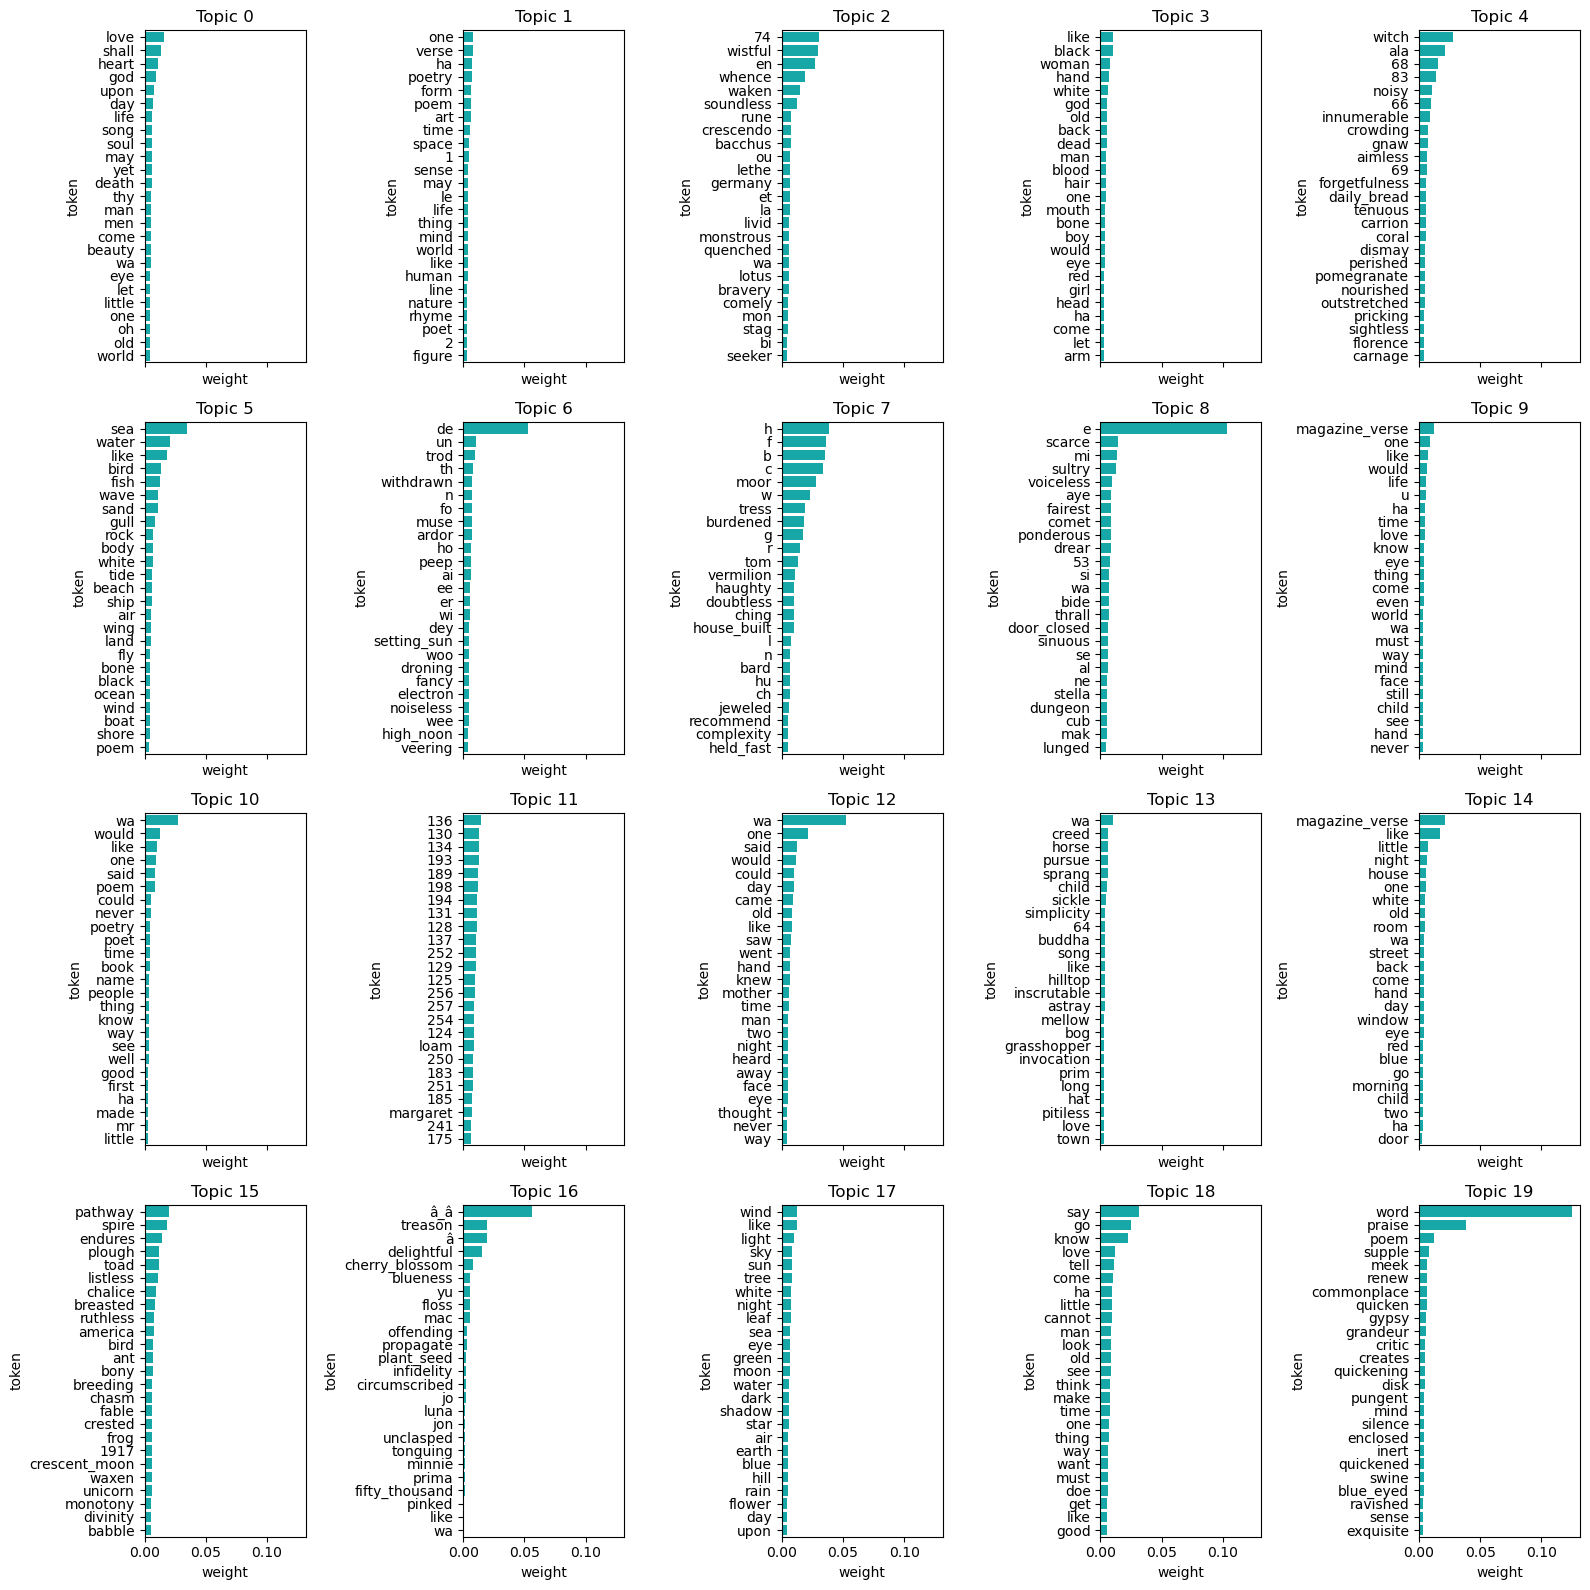

In [183]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 16), sharex=True)

for i in range(4):
    for j in range(5):
        # Calculate the starting topic number for the current subplot
        topic_num = i * 5 + j

        # Build a dataframe with columns 'token' and 'weight' for the current topic
        topic_tokens = ldag.show_topic(topic_num, topn=topn)
        df = pd.DataFrame(topic_tokens, columns=['token', 'weight'])

        # Plot the top words for the current topic
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title('Topic ' + str(topic_num))

plt.tight_layout()
plt.show()

In [184]:
from sklearn.manifold import TSNE

tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

NameError: name 'wv' is not defined